<a href="https://colab.research.google.com/github/Ighus/black_friday_pratice_problem/blob/master/predict_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA

## Configuração de ambiente

In [1]:
if 'google.colab' in str(get_ipython()):
  DEV_AMBIENT = 'colab'
else:
  DEV_AMBIENT = 'local'

In [2]:
if DEV_AMBIENT == 'local':
  # Configuração se deve ser utilizado a placa de video ou processador, 
  # se for descomentado, usará o processador
  # os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
  # print("Gpu: ", len(tf.config.experimental.list_physical_devices('GPU')))
  # Configuração de limitador de uso da memória da placa de video [precisa ser ajustado]
  folder_path = 'train.csv'
else:
  # from google.colab import drive
  # from zipfile import ZipFile
  # drive.mount('/content/gdrive')

  # !unzip "gdrive/MyDrive/Igor.ffp/Projetos DS/Bases/tcc-image-analysis-cluster/data.zip" > /dev/null
  # !unzip "gdrive/MyDrive/Igor.ffp/Projetos DS/Bases/tcc-image-analysis-cluster/train_images.zip" > /dev/null

  folder_path = 'https://raw.githubusercontent.com/Ighus/black_friday_pratice_problem/master/train.csv'

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [3]:
df = pd.read_csv(folder_path)
# test = pd.read_csv('test.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [5]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [6]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


Varificação se existem dados faltantes nas colunas do dataframe

In [7]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

Como podemos observar, as colunas Product_Category_2 e Product_Category_3 apresentam um grande volume de dados faltantes e, essa informação não pode ser descartado, por isso é preciso pensar em estratégias para essas colunas, uma delas seria dropar ambas, mas talvez esse não seria o melhor forma de lidar com a situação. Antes de tomar uma decisão, será feita uma verificação nesses dados para validar a melhor estratégia.

In [8]:
print(f"""Se optasse por remover as colunas com dados faltantes seriam retiradas um total de {colored(df.Product_Category_2.isnull().sum() + df.Product_Category_3.isnull().sum(), 'red')} de {colored(len(df), 'blue')} linhas no total presentes no dataframe estudado""")

Se optasse por remover as colunas com dados faltantes seriam retiradas um total de 556885 de 550068 linhas no total presentes no dataframe estudado


Como podemos ver seriam retiradas mais linhas do que existem no dataframe.

Agora podemos observar os dados das colunas e montar um nova estratégia.

In [9]:
display(
  df.Product_Category_2.unique(),
  df.Product_Category_3.unique()
)

array([nan,  6., 14.,  2.,  8., 15., 16., 11.,  5.,  3.,  4., 12.,  9.,
       10., 17., 13.,  7., 18.])

array([nan, 14., 17.,  5.,  4., 16., 15.,  8.,  9., 13.,  6., 12.,  3.,
       18., 11., 10.])

Existem algumas classes mas não existe nenhuma com 0, talvez seja uma boa estratégia utilizar essa classe como classe inválida para aqueles dados que não possuem dados, assim o dataframe seria totalmente preenchido e saberíamos que as classes 0 nessas colunas representariam linhas sem classe.

In [10]:
df.Product_Category_2.fillna(0, inplace=True)
df.Product_Category_3.fillna(0, inplace=True)
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

In [11]:
df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

As colunas que foram adicionadas 0 estam como float devido aos valores nulos que haviam previamente, como a coluna apresenta categorias, faria sentido passar esses dados para int

In [12]:
df.Product_Category_2 = df.Product_Category_2.astype('int64')
df.Product_Category_3 = df.Product_Category_3.astype('int64')

In [13]:
df.dtypes

User_ID                        int64
Product_ID                    object
Gender                        object
Age                           object
Occupation                     int64
City_Category                 object
Stay_In_Current_City_Years    object
Marital_Status                 int64
Product_Category_1             int64
Product_Category_2             int64
Product_Category_3             int64
Purchase                       int64
dtype: object

#### Análise dos campos User_ID e Product_ID

Agora vamos checar o as informações em relação aos produtos e usuários, primeiro verificando quantos usuários e quantos produtos temos únicos no dataframe.

In [14]:
print(f"Existem {colored(len(df.User_ID.unique()), 'yellow')} usuários únicos no dataframe e {colored(len(df.Product_ID.unique()), 'yellow')} produtos únicos no dataframe")

Existem 5891 usuários únicos no dataframe e 3631 produtos únicos no dataframe


#### Análise dos campos Gender, Age, Occupation, City_Category, Stay_In_Current_City_Years

Agora vamos observar as outras colunas e quais informações podemos retirar delas.
O comando head, info e dtype já nos deu um spoiler de como esses campos são e como foram representados.

In [15]:
for col_name in ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years']:
    print(sorted(df[col_name].unique()))

['F', 'M']
['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
['A', 'B', 'C']
['0', '1', '2', '3', '4+']


O campo gênero é binário e contém os sexos Feminino e Masculino representados em forma de caracter, já o campo de idades é do tipo string e apresenta um range de idades que o comprador se encaixa. A categoria da cidade pode representar uma classificação interna que talvez pode variar de acordo com o número de compradores em cada cidade e, fazendo um tipo de ranking de A a C. Vamos verificar em qual cidade existem mais vendas.

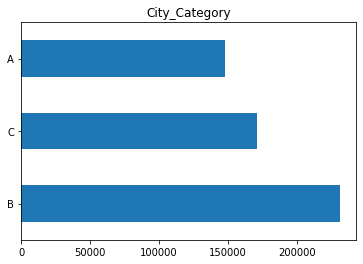

In [16]:
df['City_Category'].value_counts().plot(kind='barh', title='City_Category');

Como pudemos ver, talvez essa categorização não represente um ranking de fato, pois não existem um valor crescente de acordo com a ordem alfabética das cidades.

Agora que foi observado a categoria da cidade, podemos visualizar os demais dados e observar suas distribuições

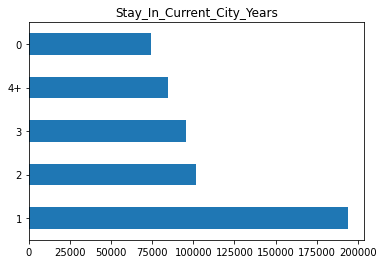

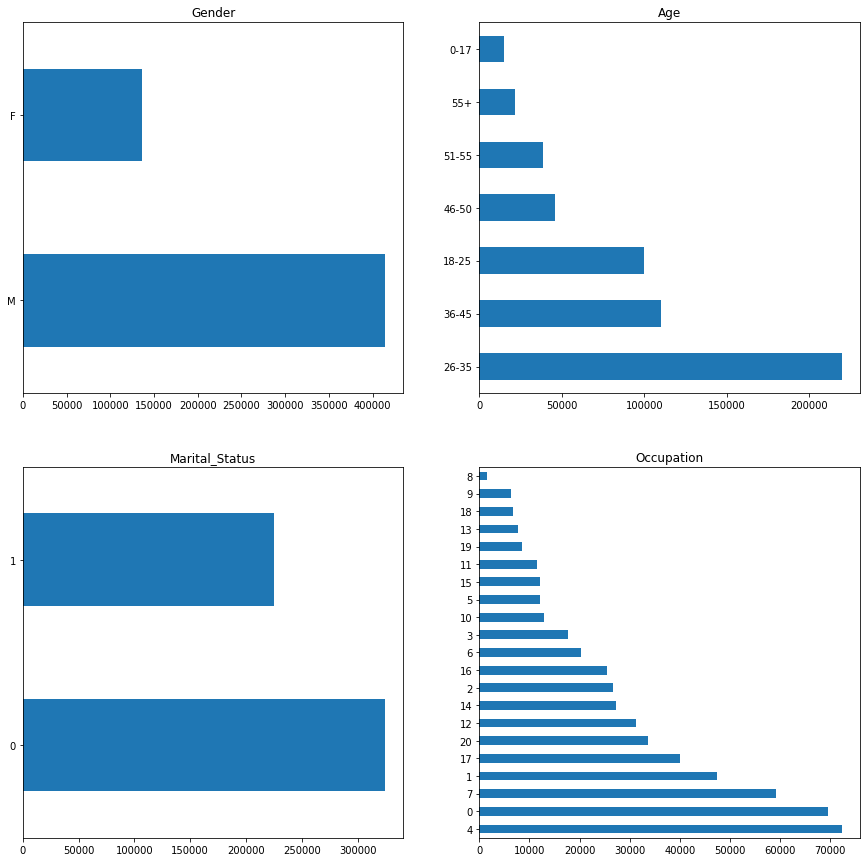

In [17]:
df['Stay_In_Current_City_Years'].value_counts().plot(kind='barh', title='Stay_In_Current_City_Years')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[15, 15])

df['Gender'].value_counts().plot(kind='barh', ax=axes[0,0], title='Gender')
df['Age'].value_counts().plot(kind='barh', ax=axes[0,1], title='Age')
df['Marital_Status'].value_counts().plot(kind='barh', ax=axes[1,0], title='Marital_Status')
df['Occupation'].value_counts().plot(kind='barh', ax=axes[1,1], title='Occupation');


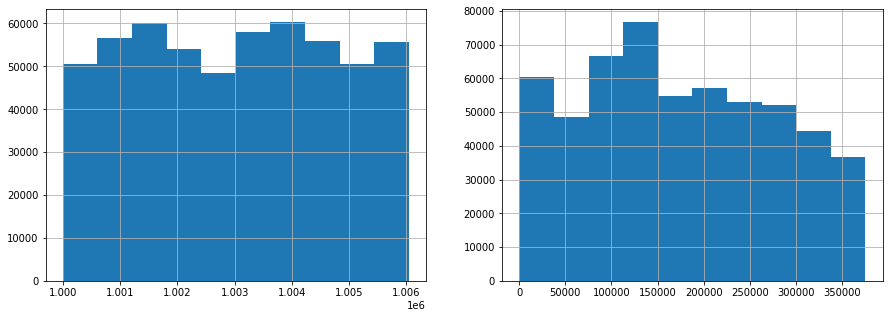

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

df['User_ID'].hist(ax=axes[0])
df['Product_ID'].apply(lambda x:int(x[1:])).hist(ax=axes[1]);

In [19]:
# Aplicando transformações
df.User_ID = df.User_ID.astype(str)
df.Product_Category_2.fillna(0, inplace=True)
df.Product_Category_3.fillna(0, inplace=True)
df.Product_Category_1 = df.Product_Category_1.astype(int)
df.Product_Category_2 = df.Product_Category_2.astype(int)
df.Product_Category_3 = df.Product_Category_3.astype(int)

# # Embaralhando o dataframe para não ter dados enviesados por ordem
# df = df.sample(frac=1).reset_index(drop=True)

# # separando train/test
# size = len(df)
# data_idx = int(size * 0.8)
# # write to disk
# df.iloc[data_idx:].to_csv('', index=False)
# df.iloc[:data_idx].to_csv(EVAL, index=False)
# print(len(df.iloc[data_idx:]), 'training records')
# print(len(df.iloc[:data_idx]), 'eval records')

# Prediction

## Imports de predição

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

import tensorflow as tf

In [21]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [22]:
target = df.Purchase

num_cols = get_cols_with_no_nans(df , 'num')
cat_cols = get_cols_with_no_nans(df , 'no_num')

In [23]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 6
Number of nun-numerical columns with no nan values : 6


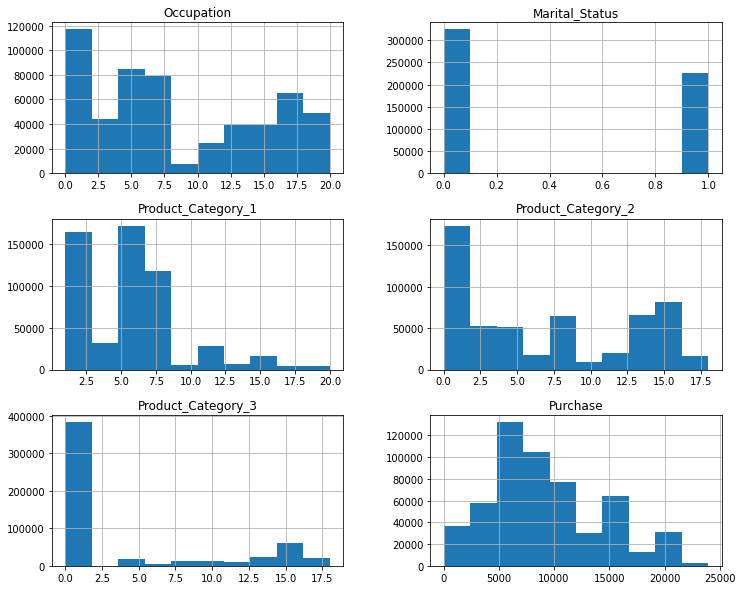

In [24]:
combined = df[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

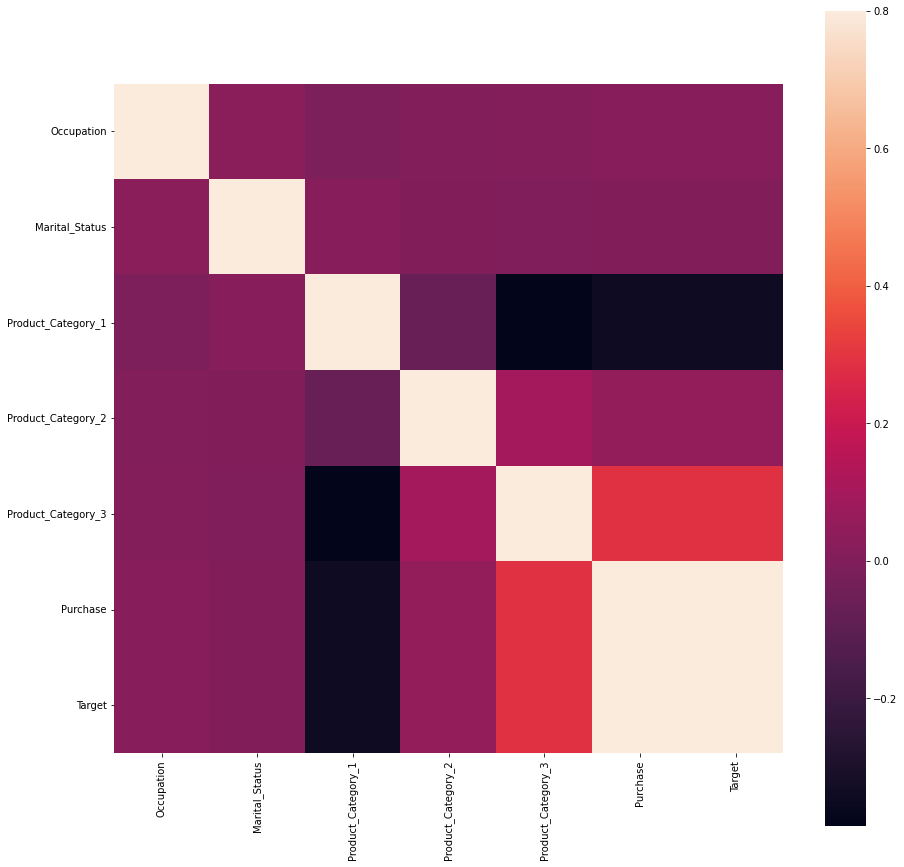

In [25]:
train_data = df[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [26]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 12 columns before encoding categorical features
There are 9545 columns after encoding categorical features


In [27]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 

train, test = split_combined()

In [28]:
NN_model = Sequential()

In [29]:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

In [30]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [31]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1221888   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,386,753
Trainable params: 1,386,753
Non-trainable params: 0
_________________________________________________________________


In [32]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [33]:
NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
32/37 [========================>.....] - ETA: 0s - loss: 4748.3574 - mean_absolute_error: 4748.3574
Epoch 1: val_loss improved from inf to 711.27234, saving model to Weights-001--711.27234.hdf5
37/37 [==============================] - 1s 17ms/step - loss: 4249.9082 - mean_absolute_error: 4249.9082 - val_loss: 711.2723 - val_mean_absolute_error: 711.2723
Epoch 2/500
32/37 [========================>.....] - ETA: 0s - loss: 525.9915 - mean_absolute_error: 525.9915
Epoch 2: val_loss improved from 711.27234 to 162.85550, saving model to Weights-002--162.85550.hdf5
37/37 [==============================] - 0s 12ms/step - loss: 504.0348 - mean_absolute_error: 504.0348 - val_loss: 162.8555 - val_mean_absolute_error: 162.8555
Epoch 3/500
34/37 [==========================>...] - ETA: 0s - loss: 153.1749 - mean_absolute_error: 153.1749
Epoch 3: val_loss improved from 162.85550 to 60.42187, saving model to Weights-003--60.42187.hdf5
37/37 [==============================] - 0s 11ms/step 

In [34]:
# predictions = NN_model.predict(test)